## Использование ALS для построения рекомендательной модели 

В этой задаче мы построим простую рекомендательную модель на основе малоранговых приближений. 

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
%matplotlib inline

### Подготовка датасета
Загрузите датасет movielens10m с [grouplens.org](https://grouplens.org/datasets/movielens/10m/) и положите архив в папку `data`. Нас будет интересовать файл `ratings.dat`, в котором собраны оценки пользователями различных фильмов с сервиса movielens.org. Вытащим этот файл из архива. Как можно узнать из соответствующей [странички](http://files.grouplens.org/datasets/movielens/ml-10m-README.html#file_desc), этот файл имеет формат `UserID::MovieID::Rating::Timestamp`. Сразу позаботимся, чтобы id пользователей и фильмов начинались с нуля (в самом файле индексация с единицы).

In [28]:
import zipfile
user_ids = []
movie_ids = []
ratings = []
with zipfile.ZipFile('data/ml-10m.zip') as archive:
    with archive.open('ml-10M100K/ratings.dat') as f:
        for l in f:
            user, movie, rating, _ = l.split(b'::')
            user_ids.append(int(user) - 1)
            movie_ids.append(int(movie) - 1)
            ratings.append(float(rating))

Составим матрицу рейтингов $A_{u,m}$, индексируемую номером пользователем и номером фильма.
Для простоты мы будем делить отзывы только на положительные (`Rating >= 4` &mdash; $A_{u,m}=1$) и отрицательные (`Rating < 4` &mdash; $A_{u,m} = 0$), таким образом, матрица у нас получится состоящей только из нулей и единиц.
Обратите внимание, что матрица будет разреженной, так как средний пользователь оценил относительно мало фильмов. Поэтому мы будем пользоваться библиотекой `scipy.sparse`. Хранить матрицу мы будем в формате [CSR](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)).

In [29]:
from scipy.sparse import csr_matrix
A = csr_matrix((np.array(ratings) >= 4, (user_ids, movie_ids)), dtype=np.float32)
A.eliminate_zeros()
print("Shape:", A.shape)
print("Ratio of nonzero elements:", A.nnz / (A.shape[0] * A.shape[1]))

Shape: (71567, 65133)
Ratio of nonzero elements: 0.0010738646228571796


Отделим некоторое количество пользователей для последующей проверки. Используем стандартное разбиение train/test 80/20.

In [30]:
n_users, n_movies = A.shape
n_test = int(n_users * 0.2)
n_train = n_users - n_test
idx = np.arange(n_users)
np.random.shuffle(idx)
test_idx, train_idx = idx[:n_test], idx[n_test:]
A_test, A_train = A[test_idx,:], A[train_idx,:]

### a. Вычисление ALS-функционала и расстояния между подпространствами

  1.  Напомним, что в методе ALS решается задача минимизации функционала $\|A - UV^\top\|_F$ по всем $U$ и $V$ заданного ранга $r$. В самом алгоритме вместо двух матриц $U$ и $V$ естественным образом возникает третья матрица $S \in \mathbb{R}^{r \times r}$, так что текущее приближение выглядит как $USV^\top$. Поэтому первым делом вам нужно будет написать функцию `als_functional` для вычисления оптимизируемого функционала $\|A - USV^\top\|_F$ для заданных $A$, $U$, $S$, $V^\top$ (матрица $S$ не обязана быть диагональной). Заметьте, что прямое вычисление этой нормы &mdash; очень трудоёмкая задача, ведь разность будет плотной матрицей. Для того, чтобы эффективно вычислить норму разности, распишите $\|A - USV^\top\|_F^2$ через скалярное произведение $(X,Y)_F = \mathrm{Tr}\,(X^\top Y)$, выполните алгебраические преобразования и покажите, как эффективно вычислить каждый член в полученном выражении. Имеется в виду, что ни на каком этапе вы не должны явно формировать плотные матрицы размеров `A.shape` (хотя numpy, скорее всего, и откажется аллоцировать 37 ГБ под такой массив). Для вычисления фробениусовой нормы разреженной матрицы используйте `norm` из `scipy.sparse.linalg`.
  
  **Замечание**: не используйте циклы по ненулевым элементам разреженной матрицы $A$. Убедитесь, что в ваши формулы входит только умножение на матрицы $A$ или $A^\top$, на которые можно умножать посредством @. 

$$
\|A - USV^T\| = (A-USV^T, A-USV^T)_F = (A,A)_F - 2(USV^T,A)_F + (USV^T, USV^T)_F = \\ = \|A\|^2 - 2Tr(A^TUSV^T) + Tr(VS^TU^TUSV^T) = \|A\|^2 - 2Tr(SV^TA^TU) + Tr(S^TU^TUSVV^T)t \text{ (по свойству перестановки следа)}
$$

In [80]:
def als_functional(A, A_norm, U, S, VT):
    """
        Input
            A: sparse 2D array
            A_norm: Frobenius norm of A
            U, S, VT: 2D arrays such that U @ S @ VT approximates A
        Output
            ||A - USVT||_F
    """
    
    A_A = A_norm ** 2
    SVTATU = np.trace(S @ VT @ A.T @ U)
    VTVSTUTUS = np.trace(S.T @ U.T @ U @ S @ VT @ VT.T)
    
    return A_A - 2 *  SVTATU + VTVSTUTUS
    
    raise NotImplementedError()

  2. Ещё одной метрикой сходимости ALS-процесса, помимо стабилизации самого функционала, может служить так называемое расстояние между подпространствами. Расстоянием между подпространствами $L_1 \subset \mathbb{R}^m$ и $L_2 \subset \mathbb{R}^m$ будем называть число $\|P(L_1) - P(L_2)\|_2$, где $P(L_i)$ &mdash; ортопроектор на $L_i$. Опишите алгоритм вычисления расстояния между двумя подпространствами $\mathrm{Im}(U_1)$ и $\mathrm{Im}(U_2)$ для заданных матриц $U_1, U_2 \in \mathbb{R}^{m \times r}$ с ортонормированными столбцами (т.е. $U_i^T U_i = I$). Алгоритм должен иметь сложность $O(mr^2)$. **Подсказка.** Воспользуйтесь фактом, что ортопроекторы являются матрицами малого ранга $r$, и техникой малоранговой арифметики, описанной на соответствующих лекции и семинаре.

У $U_1$, $U_2$ ортонормированные столбцы  $\Rightarrow $ ортопроектор на $Im(U_1), Im(U_2)$ будет иметь вид:

$$
P_U = U(U^TU)^{-1}U^T = UU^T
$$

Найдём $\|P(L_1) - P(L_2)\|_2$:

$$
\|P(U_1) - P(U_2)\|_2 = U_1U_1^T - U_2U_2^T = [U_1 \; -U_2][U_1U_2]^* = [U_1\; -U_2][U_1U_2]^T \in \mathbb{R}^{m\times (r_1+r_2)}
$$ 

Далее вычислим $QR$ разложение для $[U_1  \;-U_2]$ и для $[U_1  \;-U_2]$ за $O(m4r^2) \simeq O(mr^2)$

Затем, вычислим разложение SVD от матрицы $R_1R_2^*$. Поскольку ранг матриц $R_1,R_2 = r$ - сложность SVD составит $O(r^3)$. 

Так как $r \leqslant m \Rightarrow O(mr^2) + O(r^3) \leqslant O(mr^2) $


$\|P(L_1) - P(L_2)\|_2$ = $\|U_RS_RV_R^T\|_2$ = $S_R[0]$ *(помним из прошлой практической работы)*

  3. Напишите функцию `dist_between_subspaces`, принимающую на вход матрицы $U_1, U_2 \in \mathbb{R}^{m\times r}$ с ортонормированными столбцами, и возвращающую расстояние между $\mathrm{Im}(U_1)$ и $\mathrm{Im}(U_2)$. Сложность алгоритма должна быть $O(mr^2)$.

In [38]:
def dist_between_subspaces(U1, U2):
    """
        Input
            U1, U2: matrices with orthonormal columns
        Output
            Distance between Im(U1) and Im(U2)
    """
    Q_u1, R_u1 = np.linalg.qr(np.concatenate((U1, -U2), axis = 1))
    Q_u2, R_u2 = np.linalg.qr(np.concatenate((U1, U2), axis = 1))
    U,S,VT = np.linalg.svd(R_u1 @ R_u2.T, full_matrices=False)
    
    return S[0]
    
    raise NotImplementedError()

### b. Метод ALS
Реализуйте метод ALS (alternating least squares) с ортогонализацией (см. лекции). При указании `debug=True` печатайте номер текущей итерации и последнее расстояние между подпространствами, а также любую дополнительную интересную вам информацию. Вам будет необходимо вернуть три матрицы $U$, $S$, $V^\top$, а также список расстояний между $\mathrm{Im}(U_0)$ и $\mathrm{Im}(U_1)$, $...$, $\mathrm{Im}(U_{k-1})$ и $\mathrm{Im}(U_k)$. Матрицы $S$ не обязана быть диагональной.

In [68]:
from scipy.sparse.linalg import norm as sparse_norm

def ALS(A, rank, tolerance=1e-2, debug=False):
    """
        Input
            A: 2D m x n numpy array
            rank: required rank of the approximation
            tolerance: stop when this distance between Im(U_k) and Im(U_{k+1}) is reached
            debug: print debug information on each iteration
            
        Output
            U: m x rank numpy array with orthogonal columns
            S: rank x rank numpy array
            VT: rank x n numpy array with orthogonal rows
            dists: list of distances between Im(U_k) and Im(U_{k+1})
    """
    U = np.random.rand(A.shape[0], rank)
    V = np.random.rand(rank, A.shape[1])
    dists = []
    
    U_new = A @ V.T
    V_new = A.T @ U
    Q_1, R_1 = np.linalg.qr(U_new)
    Q_2, R_2 = np.linalg.qr(V_new)
    dists.append(dist_between_subspaces(U, Q_1))
    
    iteration = 0
    
    while dists[iteration] > tolerance:
        if debug:
            print('Iteration: {}, Distance: {}'.format(iteration, dists[iteration]))
        
        U = Q_1
        V = Q_2.T
        Q_1, R_1 = np.linalg.qr(A @ V.T)
        Q_2, R_2 = np.linalg.qr(A.T @ Q_1)
        
        dists.append(dist_between_subspaces(U, Q_1))
        
        iteration += 1
        
    if debug:
        print('Iteration: {}, Distance: {}'.format(iteration, dists[iteration]))

    return Q_1, R_2.T, Q_2.T, dists

    raise NotImplementedError()

Запустим метод на матрице `A_train` и посмотрим на убывание расстояния между соседними подпространствами от номера итерации.

Iteration: 0, Distance: 434499.99349617556
Iteration: 1, Distance: 0.9999901219608475
Iteration: 2, Distance: 0.6419731034566989
Iteration: 3, Distance: 0.41453924690726146
Iteration: 4, Distance: 0.29309698171355464
Iteration: 5, Distance: 0.24036084611733746
Iteration: 6, Distance: 0.1888803451659848
Iteration: 7, Distance: 0.14973622261928243
Iteration: 8, Distance: 0.12710731360628275
Iteration: 9, Distance: 0.11681566510522783
Iteration: 10, Distance: 0.10784190326898681
Iteration: 11, Distance: 0.09782656736010037


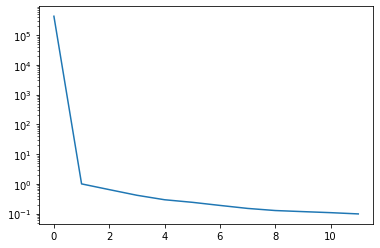

In [69]:
rank = 30
U_als, S_als, VT_als, dist_als = ALS(A_train, rank, 0.1, debug=True)
plt.plot(dist_als)
_ = plt.semilogy()

### c. Сравнение с рандомизированным SVD и разреженным SVD

Примените рандомизированное SVD из sklearn, а также разреженное SVD из scipy (используйте тот же ранг 30, что и для ALS). Сравните все три результата по значению функционала.

In [81]:
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

A_norm = sparse_norm(A_train)
 
U_0, S_0, VT_0 = randomized_svd(A_train, n_components = 30)
U_1, S_1, VT_1 = svds(A_train, k=30)
S_0 = np.diag(S_0)
S_1 = np.diag(S_1)

print('ALS: {}'.format(als_functional(A_train, A_norm, U_als, S_als, VT_als)))
print('Random: {}'.format(als_functional(A_train, A_norm, U_0, S_0, VT_0)))
print('Sparsed: {}'.format(als_functional(A_train, A_norm, U_1, S_1, VT_1)))
# TO BE FILLED

ALS: 2677829.7149890484
Random: 2676990.3054319024
Sparsed: 2676642.6804319024


### d.  Построение рекомендаций
Научимся рекомендовать пользователям из тестовой группы фильмы на основе части их оценок. Напишем функцию `recommend`, которая будет принимать матрицу $V^\top$ из нашей модели, матрицу `(user_id, movie_id) -> binary rating` (то есть того же формата, что и наша основная матрица `A`), а также число `n_recs` &mdash; количество фильмов, которые мы хотим порекомендовать. Возвращать функция будет top-`n_recs` рекомендаций, то есть `n_recs` фильмов, которые могут пользователю понравиться, в порядке убывания предсказанной привлекательности.

Чтобы построить рекомендацию, необходимо ортогонально спроецировать вектор, соответствующий новому пользователю (про которого мы знаем часть оценок), на пространство $L$, образуемое строками матрицы $V^\top$. Иными словами, мы должны взять ближайший вектор из $L$. Он будет содержать предсказанные нашей моделью рейтинги. Дальше дело техники :) Но не забудьте, что `known_ratings` содержит векторы, соответствующие не одному пользователю, а батчу из `batch_size` пользователей. Хотя и (слава numpy) код остаётся почти дословно такой же.

In [134]:
def recommend(VT, known_ratings, n_recs):
    """
        Input
            VT: 2D numpy array
            known_rating: sparse batch_size x n_movies array
            n_recs: requested number of recommendations
            
        Output
            recs: batch_size x n_recs array of movies to recommend, with descending predicted rating
    """
    users = list()
    for user in range(known_ratings.shape[0]):
        user_rating = known_ratings[user]
        predict = VT.T @ (VT @ user_rating.T) # столбец рекоментаций
        movies_dict = [(predict[i][0], i) for i in range(known_ratings.shape[1])]
        movies_dict.sort(key=lambda x: x[0])
        user_recs = list()
        for i in range(known_ratings.shape[1]-1, known_ratings.shape[1] - 1 - n_recs, -1):
            user_recs.append(movies_dict[i][1])
#         print(user_recs)
        users.append(user_recs)
    
    return np.array(users)
    raise NotImplementedError()

Для проверки нашей модели для каждого пользователя из тестовой выборки оценим так называемый **hit rate**. Для этого выбросим одну из его оценок, вызовем функцию `recommend` и посмотрим, попал ли выкинутый фильм в подборку. Если попал &mdash; это hit, иначе не hit. Для того, чтобы эффективно проделать этот эксперимент на всех тестовых данных, сделаем следующее: разобьём тестовую матрицу на батчи по 500 пользователей и будем предсказывать сразу для целого батча. Вычислим вектор размера `n_test`, где для каждого пользователя указано, на каком месте в рекомендованной подборке оказался скрытый фильм (или число `n_recs`, если скрытого фильма не нашлось среди top-n  рекомендаций).

In [83]:
from scipy.sparse import find

def evaluate_model(VT, A_test, n_recs, batch_size=500):
    """
        Input
            VT: 2D numpy array representing the rating model
            A_test: sparse n_test x n_movies array corresponding to new users
            n_recs: requested number of recommendations
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie 
                     in top-n_recs recommendations (or n_recs if it is missing)
    """
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user,:])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        # Build recomendations for a batch.
        recommendations = recommend(VT, A_test[nonempty_users[i:i + batch_size], :], n_recs + 1)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:,-1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    return hit_idx

Научимся вычислять hit rate для данной модели и заданного количества top-n рекомендаций. Для этого напишем функцию `get_hit_rates`, которая будет принимать $V^\top$ из нашей модели, вектора оценок для новых пользователей `A_test` и список натуральных чисел `n_recs`. Для каждого из этих чисел необходимо посчитать средний hit rate по всем пользователям из `A_test`, то есть, например, для `n_recs == [5, 10, 20]` нужно вернуть список средних хитрейтов для top-5, top-10 и top-20. **Обратите внимание:** вызвать функцию `evaluate_model` нужно только один раз.

In [128]:
def get_hit_rates(VT, A_test, n_recs):
    """
        Input
            VT: 2D numpy array representing the rating model
            A_test: sparse n_test x n_movies array corresponding to new users 
            n_recs: list of ints: number of top recomendations to evaluate hit rate for
        Output
            hit_rates: list of float: hit rate for each element of n_recs
    
    """
    
    hit_rates = list()
    recs = evaluate_model(VT, A_test, max(n_recs))
    
    for i in range(len(n_recs)):
        current_top = n_recs[i]
        
        liked = 0
        for rec in recs:
            if rec < current_top:
                liked += 1
        
        hit_rates.append(liked / len(recs) * 100)
    
    return hit_rates
    raise NotImplementedError()

Проверьте себя: вычислите хитрейт на top-10 рекомендаций для Sparse SVD ранга 30. Чтобы вычисления рекомендаций были побыстрее, используйте не всю матрицу `A_test`, а, например, первые 1000 строк. Хитрейт должен получится в районе 12-15%. Самое время подебажить своё решение, если числа сильно расходятся.

In [135]:
U, S, VT = svds(A_test[:1000], k = 30)
get_hit_rates(VT, A_test[:1000], [10])

[14.492753623188406]

Теперь можно построить графики зависимости hit rate от количества рекомендаций, а также от ранга модели. Сравним результаты, которые дают три алгоритма: ALS, Sparse SVD и рандомизированный SVD.

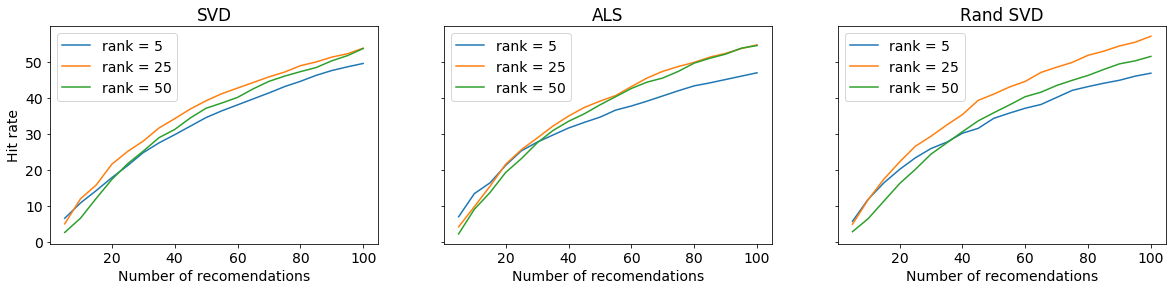

In [138]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import randomized_svd as rand_svd

n_recs = list(range(5, 101, 5))

plt.rcParams.update({'font.size': 14})
_, (ax_svd, ax_als, ax_rand) = plt.subplots(1,3,figsize=(20, 4),sharey=True)

ax_svd.set_title("SVD")
ax_svd.set_ylabel("Hit rate")
ax_als.set_title("ALS")
ax_rand.set_title("Rand SVD")
for rank in [5, 25, 50]:
    _, _, VT_svd = svds(A_train, k=rank)
    _, _, VT_als, _ = ALS(A_train, rank)
    _, _, VT_rand = rand_svd(A_train, rank)
    for VT, ax in zip([VT_svd, VT_als, VT_rand], [ax_svd, ax_als, ax_rand]):
        ax.set_xlabel("Number of recomendations")
        hit_rates = get_hit_rates(VT, A_test[:1000,:], n_recs)
        line, = ax.plot(n_recs, hit_rates)
        line.set_label('rank = {}'.format(rank))
        ax.legend()

Какой ранг приближения оказался оптимальным для нашей модели в случае каждого алгоритма?

Оптимальнее всего ранг 25, рейтинг рекомендаций выше всего